# Travaux existants
  - https://www.kaggle.com/code/dennisho/blackjack-analysis

# Contexte

Le Blackjack, un des jeux de casino les plus populaires, met en scène une confrontation entre joueur(s) et croupier. Le principe est simple : obtenir une main supérieure à celle du croupier sans dépasser 21 points. La particularité du jeu réside dans son déroulement - le joueur agit en premier, ce qui confère naturellement un avantage statistique au casino.

Bien que diverses stratégies mathématiquement prouvées existent pour optimiser les chances du joueur, notre étude adopte une approche différente. Nous nous concentrons sur l'analyse d'un vaste ensemble de données de 50 millions de mains de Blackjack pour développer un modèle prédictif. L'objectif est d'anticiper l'issue d'une partie (victoire, défaite ou égalité) en se basant uniquement sur les données statistiques.

Notre jeu de données est issu de simulations intégrant certaines variations par rapport aux règles classiques du Blackjack. Ces spécificités sont documentées et prises en compte dans notre analyse. Pour la compréhension de cette étude, une connaissance basique des règles suffit, bien que des ressources détaillées soient disponibles pour approfondir les mécaniques du jeu.

Cette recherche s'inscrit dans une démarche de classification multiclasse, exploitant un volume de données conséquent pour extraire des patterns significatifs et développer un modèle prédictif robuste.

# Exploration des données

In [ ]:
!python -m pip install pandas seaborn numpy kagglehub

import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from math import nan
import warnings

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings('ignore')

Plutôt que d'utiliser les 50 millions de mains disponibles, ce qui demanderait beaucoup trop de ressources, nous avons choisi de travailler sur un échantillon de 30 000 mains. Cela nous permet d'avoir suffisamment de données pour une analyse pertinente, tout en gardant des temps de calcul raisonnables.

Tout d'abord, téléchargons le dataset grâce au module Kaggle

In [ ]:
raw_data_path = kagglehub.dataset_download("dennisho/blackjack-hands")

print("Téléchargement du dataset réussi")

Téléchargement du dataset réussi


In [ ]:
data = pd.read_csv(
  f"{raw_data_path}/blackjack_simulator.csv",
  sep=",",
  nrows=30000
)

print("Dataset chargé")

Dataset chargé


Dans notre première phase de nettoyage des données, nous allons :


1.   Supprimer la colonne 'shoe_id' qui n'apporte rien à notre analyse
2.   Garder les variables 'run_count' et 'true_count' qui serviront pour notre modèle
3.   Corriger le format des données en transformant les chaînes de caractères qui représentent des listes en vraies listes Python

Un premier examen des données nous montre qu'il n'y a pas de valeurs manquantes, ce qui est une bonne nouvelle pour la suite. On note cependant une particularité : quand un joueur sépare ses cartes (split), l'enregistrement des actions n'est pas tout à fait standard. Nous devrons corriger cela plus tard dans notre analyse.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shoe_id             30000 non-null  int64  
 1   cards_remaining     30000 non-null  int64  
 2   dealer_up           30000 non-null  int64  
 3   initial_hand        30000 non-null  object 
 4   dealer_final        30000 non-null  object 
 5   dealer_final_value  30000 non-null  object 
 6   player_final        30000 non-null  object 
 7   player_final_value  30000 non-null  object 
 8   actions_taken       30000 non-null  object 
 9   run_count           30000 non-null  int64  
 10  true_count          30000 non-null  int64  
 11  win                 30000 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 2.7+ MB


Aucun objets null n'est présent.

In [ ]:
type(data['initial_hand'][1]), type(data['dealer_final'][1])

(str, str)

On voit que les listes des mains du joueur et du dealer sont en fait des strings, nous allons donc devoir nettoyer les données pour qu'elles soient dans un format favorable à l'entraînement.

# Nettoyage et restructuration des données

En examinant nos données de plus près, nous avons remarqué que certaines colonnes contenaient des listes, mais sous forme de texte. Par exemple, les cartes du joueur étaient enregistrées comme des chaînes de caractères plutôt que comme de vraies listes Python. Pour corriger cela, nous avons converti cinq colonnes importantes :

- Les cartes initiales
- Les cartes finales du croupier
- Les cartes finales du joueur
- Les valeurs finales des mains du joueur
- Les actions prises pendant le jeu

In [ ]:
data['initial_hand'] = data['initial_hand'].apply(lambda x: ast.literal_eval(x))
data['dealer_final'] = data['dealer_final'].apply(lambda x: ast.literal_eval(x))
data['player_final'] = data['player_final'].apply(lambda x: ast.literal_eval(x))
data['player_final_value'] = data['player_final_value'].apply(lambda x: ast.literal_eval(x))
data['actions_taken'] = data['actions_taken'].apply(lambda x: ast.literal_eval(x))

Ensuite, nous avons dû corriger un problème spécifique concernant les actions de "split" (séparation des cartes). Dans les données originales, quand un joueur séparait ses cartes, l'action n'était pas correctement enregistrée dans toutes les mains qui en résultaient. Nous avons écrit un code qui ajoute automatiquement l'action "P" (split) au début de chaque nouvelle main créée.

In [ ]:
def add_p_prefix(actions):
    return [actions[0]] + [['P'] + action for action in actions[1:]]

data['actions_taken'] = data['actions_taken'].apply(add_p_prefix)

In [ ]:
data.iloc[6]

,6
shoe_id,0
cards_remaining,383
dealer_up,6
initial_hand,"[3, 3]"
dealer_final,"[6, 10, 10]"
dealer_final_value,26
player_final,"[[3, 2, 10], [3, 4, 5]]"
player_final_value,"[15, 12]"
actions_taken,"[[P, H, S], [P, H, S]]"
run_count,-1


Le problème est réglé

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shoe_id             30000 non-null  int64  
 1   cards_remaining     30000 non-null  int64  
 2   dealer_up           30000 non-null  int64  
 3   initial_hand        30000 non-null  object 
 4   dealer_final        30000 non-null  object 
 5   dealer_final_value  30000 non-null  object 
 6   player_final        30000 non-null  object 
 7   player_final_value  30000 non-null  object 
 8   actions_taken       30000 non-null  object 
 9   run_count           30000 non-null  int64  
 10  true_count          30000 non-null  int64  
 11  win                 30000 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 2.7+ MB


Une particularité importante de nos données est que certaines lignes contiennent les informations de plusieurs mains (suite à un split). Pour simplifier notre analyse, nous avons décidé de restructurer nos données pour avoir une seule main par ligne. En utilisant la fonction "explode" de pandas, nous passons d'une structure complexe à une structure plus claire, ce qui a ajoute plusieurs milliers de nouvelles lignes à notre jeu de données.

In [ ]:
data = data.explode(['player_final','player_final_value','actions_taken'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30838 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shoe_id             30838 non-null  int64  
 1   cards_remaining     30838 non-null  int64  
 2   dealer_up           30838 non-null  int64  
 3   initial_hand        30838 non-null  object 
 4   dealer_final        30838 non-null  object 
 5   dealer_final_value  30838 non-null  object 
 6   player_final        30838 non-null  object 
 7   player_final_value  30838 non-null  object 
 8   actions_taken       30838 non-null  object 
 9   run_count           30838 non-null  int64  
 10  true_count          30838 non-null  int64  
 11  win                 30838 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 3.1+ MB


Cette restructuration était nécessaire pour plusieurs raisons :

- Elle simplifie les calculs futurs
- Elle rend les données plus faciles à analyser
- Elle permet une meilleure application de nos modèles d'apprentissage

Cette étape de nettoyage est cruciale car elle nous permettra d'avoir des résultats plus précis et plus fiables dans la suite de notre analyse.

In [ ]:
def cards_splitter(data,cards,text):
    stopsign = cards.apply(lambda x: len(x))
    for i in range(1,max(stopsign)):
        data[f'{text}{i}'] = cards.apply(lambda x: nan if len(x)<i else x[i-1])

In [ ]:
cards_splitter(data,data['player_final'],'player_card_')
cards_splitter(data,data['dealer_final'],'dealer_card_')
cards_splitter(data,data['actions_taken'],'action_taken_')

In [ ]:
data.sample(5)

,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,...,dealer_card_3,dealer_card_4,dealer_card_5,dealer_card_6,action_taken_1,action_taken_2,action_taken_3,action_taken_4,action_taken_5,action_taken_6
19993,328,342,2,"[11, 10]","[2, 10, 2, 10]",24,"[11, 10]",BJ,[S],-5,...,2.0,10.0,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
19375,318,338,10,"[3, 6]","[10, 5, 10]",25,"[3, 6, 7, 11]",17,"[H, H, S]",5,...,10.0,NaN,NaN,NaN,H,H,S,NaN,NaN,NaN
17073,280,339,4,"[9, 10]","[4, 10, 6]",20,"[9, 10]",19,[S],-11,...,6.0,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
24996,410,151,10,"[9, 10]","[10, 9]",19,"[9, 10]",19,[S],20,...,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
17193,282,345,8,"[8, 10]","[8, 8, 4]",20,"[8, 10]",18,[S],7,...,4.0,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30838 entries, 0 to 29999
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shoe_id             30838 non-null  int64  
 1   cards_remaining     30838 non-null  int64  
 2   dealer_up           30838 non-null  int64  
 3   initial_hand        30838 non-null  object 
 4   dealer_final        30838 non-null  object 
 5   dealer_final_value  30838 non-null  object 
 6   player_final        30838 non-null  object 
 7   player_final_value  30838 non-null  object 
 8   actions_taken       30838 non-null  object 
 9   run_count           30838 non-null  int64  
 10  true_count          30838 non-null  int64  
 11  win                 30838 non-null  float64
 12  player_card_1       30838 non-null  int64  
 13  player_card_2       30838 non-null  int64  
 14  player_card_3       13758 non-null  float64
 15  player_card_4       3684 non-null   float64
 16  player_ca

In [ ]:
data['is_blackjack_dealer'] = data['dealer_final_value'].where(data['dealer_final_value'] == 'BJ').fillna(0).replace('BJ',1)
data['is_blackjack_player'] = data['player_final_value'].where(data['player_final_value'] == 'BJ').fillna(0).replace('BJ',1)

In [ ]:
data['dealer_final_value'] = data['dealer_final_value'].replace('BJ',21)
data['player_final_value'] = data['player_final_value'].replace('BJ',21)

In [ ]:
data['dealer_final_value'] = data['dealer_final_value'].astype('int64')
data['player_final_value'] = data['player_final_value'].astype('int64')

In [ ]:
data.loc[(data['dealer_final_value'] < data['player_final_value']) & (data['player_final_value'] <= 21) , 'win'] = 1
data.loc[data['dealer_final_value'] >  21 , 'win'] = 1
data.loc[data['dealer_final_value'] == data['player_final_value'], 'win'] = 0
data.loc[(data['dealer_final_value'] > data['player_final_value']) & (data['dealer_final_value'] <= 21) , 'win'] = -1
data.loc[data['player_final_value'] > 21 , 'win'] = -1
data['win'] = data['win'].astype('int64')

Pour rendre nos données plus exploitables, nous avons réalisé plusieurs transformations importantes :

### 1. Séparation des cartes
Nous avons créé une fonction `cards_splitter` qui sépare les cartes de chaque main en colonnes individuelles. Cette approche nous permet d'avoir une vue plus détaillée des cartes du joueur et du croupier à chaque étape du jeu.

### 2. Gestion des Blackjacks  
Pour faciliter l'analyse numérique, nous avons standardisé la représentation des Blackjacks :
- Création de deux colonnes 'is_blackjack_player' et 'is_blackjack_dealer' (0 ou 1)
- Remplacement de la valeur 'BJ' par 21
- Conversion des valeurs en format numérique entier

### 3. Classification des résultats
Nous avons simplifié la représentation des résultats en trois catégories :
- Victoire : 1
- Égalité : 0
- Défaite : -1

Cette classification se base sur les règles suivantes :
- Le joueur gagne si sa main est supérieure à celle du croupier (sans dépasser 21)
- Le joueur gagne si le croupier dépasse 21
- Égalité si les mains sont identiques
- Défaite si la main du croupier est supérieure (sans dépasser 21)
- Défaite si le joueur dépasse 21

Ces transformations permettent d'avoir des données propres et structurées, essentielles pour la phase de modélisation qui suivra.


In [ ]:
data.sample(5)

,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,...,dealer_card_5,dealer_card_6,action_taken_1,action_taken_2,action_taken_3,action_taken_4,action_taken_5,action_taken_6,is_blackjack_dealer,is_blackjack_player
8874,146,407,9,"[9, 11]","[9, 6, 7]",22,"[9, 11]",20,[S],-4,...,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,0,0
1560,25,209,10,"[3, 9]","[10, 9]",19,"[3, 9, 3, 10]",25,"[H, H]",2,...,NaN,NaN,H,H,NaN,NaN,NaN,NaN,0,0
12010,197,246,10,"[8, 9]","[10, 9]",19,"[8, 9]",17,[S],-13,...,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,0,0
4192,69,365,8,"[9, 9]","[8, 9]",17,"[9, 7, 2]",18,"[P, H, S]",2,...,NaN,NaN,P,H,S,NaN,NaN,NaN,0,0
6133,100,84,10,"[10, 10]","[10, 10]",20,"[10, 10]",20,[S],-5,...,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,0,0


# Analyse

L'analyse de notre jeu de données révèle des informations importantes sur la distribution des résultats :

In [ ]:
data['win'].value_counts()

,count
win,
-1,14826
1,13345
0,2667


In [ ]:
print(data['win'].value_counts(normalize=True))

print(f"Total des wins : {sum(data['win'])}")

win
-1    0.480770
 1    0.432745
 0    0.086484
Name: proportion, dtype: float64
Total des wins : -1481


Nos données montrent une répartition des résultats cohérente avec les probabilités théoriques du Blackjack :
- Défaites : ~48%
- Victoires : ~44%
- Égalités : ~8%

Cette distribution confirme que notre classification est correcte, malgré un déséquilibre apparent entre les classes. Cette asymétrie est en fait une caractéristique intrinsèque du jeu, confirmée par la théorie des probabilités du Blackjack.

On voit très clairement que le joueurs est perdant sur le long terme (-1481 de wins, ce qui signifie qu'il y a plus de -1 que de 1, donc plus de défaites que de victoires)

In [ ]:
data['dealer_up'].value_counts()

,count
dealer_up,
10,9318
6,2496
5,2492
4,2441
3,2433
2,2399
7,2369
8,2332
9,2316


Le nombre 10 apparait plus de fois ce qui est normal car comparé aux autres cartes, le 10 peut etre obtenu via 10, J, Q, K. Donc 4 fois plus de chance de tomber sur un 10.

In [ ]:
data['actions_taken'].astype(str).value_counts().head(30)

,count
actions_taken,
['S'],12730
"['H', 'S']",4155
['D'],2946
['H'],1966
"['H', 'H', 'S']",1463
['R'],1222
"['H', 'H']",1217
['N'],701
[],684


On remarque des liste vide. La seule option est qu'il y ai eu un BlackJack directement, donc aucune action effectué après. (Faudra cependant confirmer cette théorie)

In [ ]:
data[['dealer_up','win']].groupby('dealer_up')['win'].mean().sort_values(ascending=False)

,win
dealer_up,
6,0.176683
5,0.094703
4,0.086850
7,0.078514
3,0.059186
2,0.025427
8,0.015437
9,-0.061744
10,-0.196501


In [ ]:
data['initial_hand'] = data['initial_hand'].astype(str)
data[['initial_hand','win']].groupby('initial_hand')['win'].mean().sort_values(ascending=False)

,win
initial_hand,
"[10, 11]",0.869263
"[11, 10]",0.867123
"[11, 9]",0.621622
"[10, 10]",0.572765
"[9, 11]",0.542105
...,...
"[4, 9]",-0.434524
"[8, 6]",-0.441860
"[8, 9]",-0.441989


Les deux premières mains sont des BlackJack, la win n'est pas à 100% car la main en face peut aussi avoir un BlackJack, ce qui fait un push (égalité).

In [ ]:
data['initial_hand'] = data['initial_hand'].astype(str)
data[['initial_hand','win']].groupby('initial_hand')['win'].value_counts().head(25)

initial_hand  win
[10, 10]       1     1979
               0      581
              -1      326
[10, 11]       1      625
               0       94
[10, 2]       -1      406
               1      245
               0       26
[10, 3]       -1      458
               1      248
               0       29
[10, 4]       -1      466
               1      221
               0       22
[10, 5]       -1      476
               1      211
               0       10
[10, 6]       -1      485
               1      195
               0        4
[10, 7]       -1      386
               1      207
               0       87
[10, 8]       -1      328
               1      314
Name: count, dtype: int64

# Graphiques

Pour mieux comprendre les patterns de jeu optimaux, nous avons développé deux fonctions d'analyse importantes :

In [ ]:
def hands_normalizer(data,maxhandsnum):
    for i in range(1,maxhandsnum+1):
        if i == 1:
            data.loc[(data.loc[:,'cards_sum'] > 21) & ((data.loc[:,f'player_card_{i}'] == 11) | (data.loc[:,f'player_card_{i+1}'] == 11)) ,'cards_sum']  -= 10
            continue
        elif i == 2:
            continue
        else:
            data.loc[(data.loc[:,'cards_sum'] > 21) & (data.loc[:,f'player_card_{i}'] == 11) ,'cards_sum']  -= 10

Cette fonction gère la particularité de l'As dans le Blackjack, qui peut valoir 1 ou 11 :
- Ajuste automatiquement la valeur de l'As de 11 à 1 quand la somme dépasse 21
- S'applique de manière séquentielle sur toutes les cartes de la main
- Permet d'avoir une représentation cohérente des sommes des mains

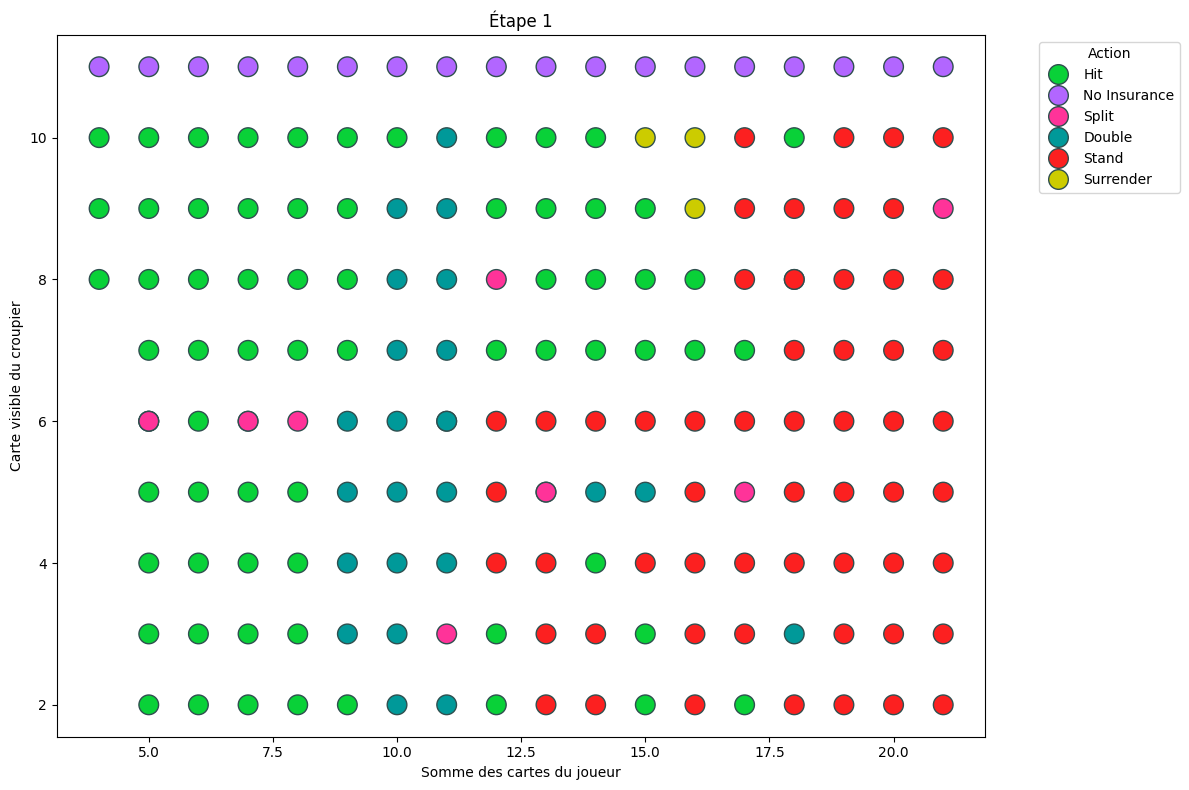

In [ ]:
def step_graph_generator_sns(data, step):
    # Colonnes
    columns = ['dealer_up', 'win']
    hands = [f'player_card_{i}' for i in range(1, step + 2)]
    columns = columns + [f'action_taken_{step}'] + hands

    graphdata = data[columns].copy()
    graphdata['cards_sum'] = graphdata['player_card_1']
    for i in range(2, step + 2):
        graphdata.loc[:, 'cards_sum'] += graphdata.loc[:, f'player_card_{i}']

    hands_normalizer(graphdata, step + 1)

    # Filtre des données
    Graph = graphdata.query('win == 1')
    Graph['Counts'] = Graph.groupby(['cards_sum', 'dealer_up'])[
        f'action_taken_{step}'
    ].transform('count')
    MaxIndex = Graph.groupby(['cards_sum', 'dealer_up'])['Counts'].idxmax()
    FinalGraph = (
        Graph.loc[MaxIndex, :]
        .sort_values(['cards_sum', 'dealer_up'])
        .fillna('No Data')
    )

    FinalGraph = FinalGraph.replace({
        'S': 'Stand',
        'H': 'Hit',
        'D': 'Double',
        'P': 'Split',
        'R': 'Surrender',
        'N': 'No Insurance',
    })

    # Choix des couleurs, le même pour tout les graphes par cohérence
    color_map = {
        'Stand': '#FC2020',
        'Hit': '#09D138',
        'Double': "#009999",
        'Split': '#FF3399',
        'Surrender': "#CCCC00",
        'No Insurance': "#B266FF",
        'No Data': '#C0C0C0',
    }

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=FinalGraph,
        x='cards_sum',
        y='dealer_up',
        hue=f'action_taken_{step}',
        palette=color_map,
        s=200,
        edgecolor='darkslategrey',
        linewidth=1,
    )

    plt.title(f'Étape {step}')
    plt.xlabel("Somme des cartes du joueur")
    plt.ylabel("Carte visible du croupier")
    plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    return plt

# afficher une étape en particulier (1 par défaut)
step_graph_generator_sns(data, 1)
plt.show()

Cette fonction crée une visualisation détaillée des meilleures actions à prendre selon :
- La somme des cartes du joueur
- La carte visible du croupier
- L'étape du jeu en cours

Le graphique utilise un code couleur intuitif :
- Rouge (Stand) : Rester
- Vert (Hit) : Tirer une carte
- Bleu (Double) : Doubler la mise
- Rose (Split) : Séparer les cartes
- Jaune (Surrender) : Abandonner
- Violet (No Insurance) : Pas d'assurance

Cette visualisation nous permet d'identifier rapidement les stratégies optimales en fonction de la situation de jeu, basées sur les données réelles plutôt que sur des intuitions.

Pour compléter notre analyse, nous avons créé une deuxième visualisation qui montre la distribution complète des actions plutôt que seulement les actions optimales :

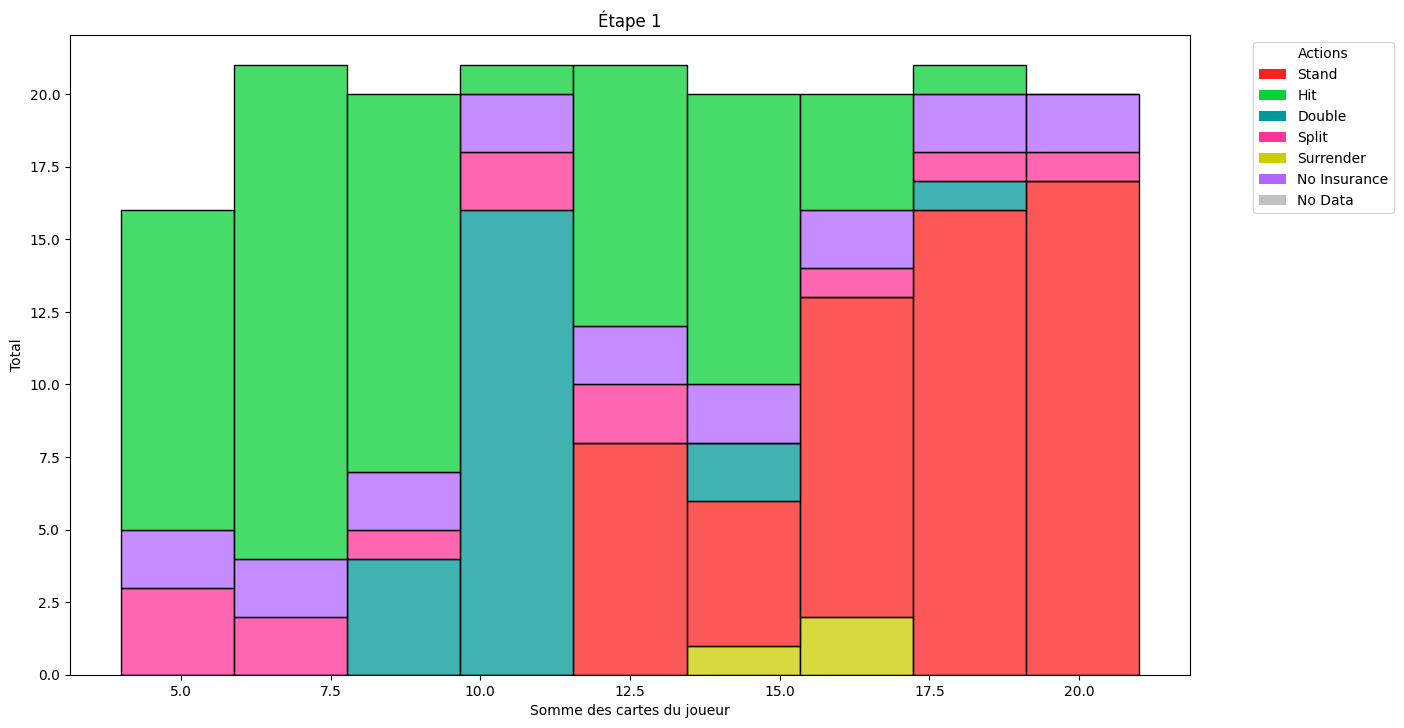

In [ ]:
def step_bar_graph_generator_sns(data, step):
    columns = ['dealer_up', 'win']
    hands = [f'player_card_{i}' for i in range(1, step + 2)]
    columns = columns + [f'action_taken_{step}'] + hands

    graphdata = data[columns].copy()
    graphdata['cards_sum'] = graphdata['player_card_1']
    for i in range(2, step + 2):
        graphdata.loc[:, 'cards_sum'] += graphdata.loc[:, f'player_card_{i}']

    hands_normalizer(graphdata, step + 1)

    Graph = graphdata.query('win == 1')
    Graph['Counts'] = Graph.groupby(['cards_sum', 'dealer_up'])[
        f'action_taken_{step}'
    ].transform('count')
    MaxIndex = Graph.groupby(['cards_sum', 'dealer_up'])['Counts'].idxmax()
    FinalGraph = (
        Graph.loc[MaxIndex, :]
        .sort_values(['cards_sum', 'dealer_up'])
        .fillna('No Data')
    )

    FinalGraph = FinalGraph.replace({
        'S': 'Stand',
        'H': 'Hit',
        'D': 'Double',
        'P': 'Split',
        'R': 'Surrender',
        'N': 'No Insurance',
    })

    color_map = {
        'Stand': '#FC2020',
        'Hit': '#09D138',
        'Double': "#009999",
        'Split': '#FF3399',
        'Surrender': "#CCCC00",
        'No Insurance': "#B266FF",
        'No Data': '#C0C0C0',
    }

    plt.figure(figsize=(16, 8))

    ax = plt.axes([0.1, 0.1, 0.7, 0.8])

    sns.histplot(
        data=FinalGraph,
        x='cards_sum',
        hue=f'action_taken_{step}',
        palette=color_map,
        multiple="stack",
        ax=ax
    )

    plt.title(f'Étape {step}')
    plt.xlabel("Somme des cartes du joueur")
    plt.ylabel("Total")

    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor=color, label=action)
        for action, color in color_map.items()
    ]

    ax.legend(
        handles=legend_elements,
        title='Actions',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )

    plt.tight_layout()

    return plt

# First step
step_bar_graph_generator_sns(data, 1)
plt.show()

Notre nouvelle fonction `step_bar_graph_generator_sns` crée un histogramme empilé qui montre :
- La distribution des actions pour chaque somme de cartes
- La fréquence relative de chaque action
- La répartition complète des décisions gagnantes

Le graphique utilise le même code couleur que précédemment.

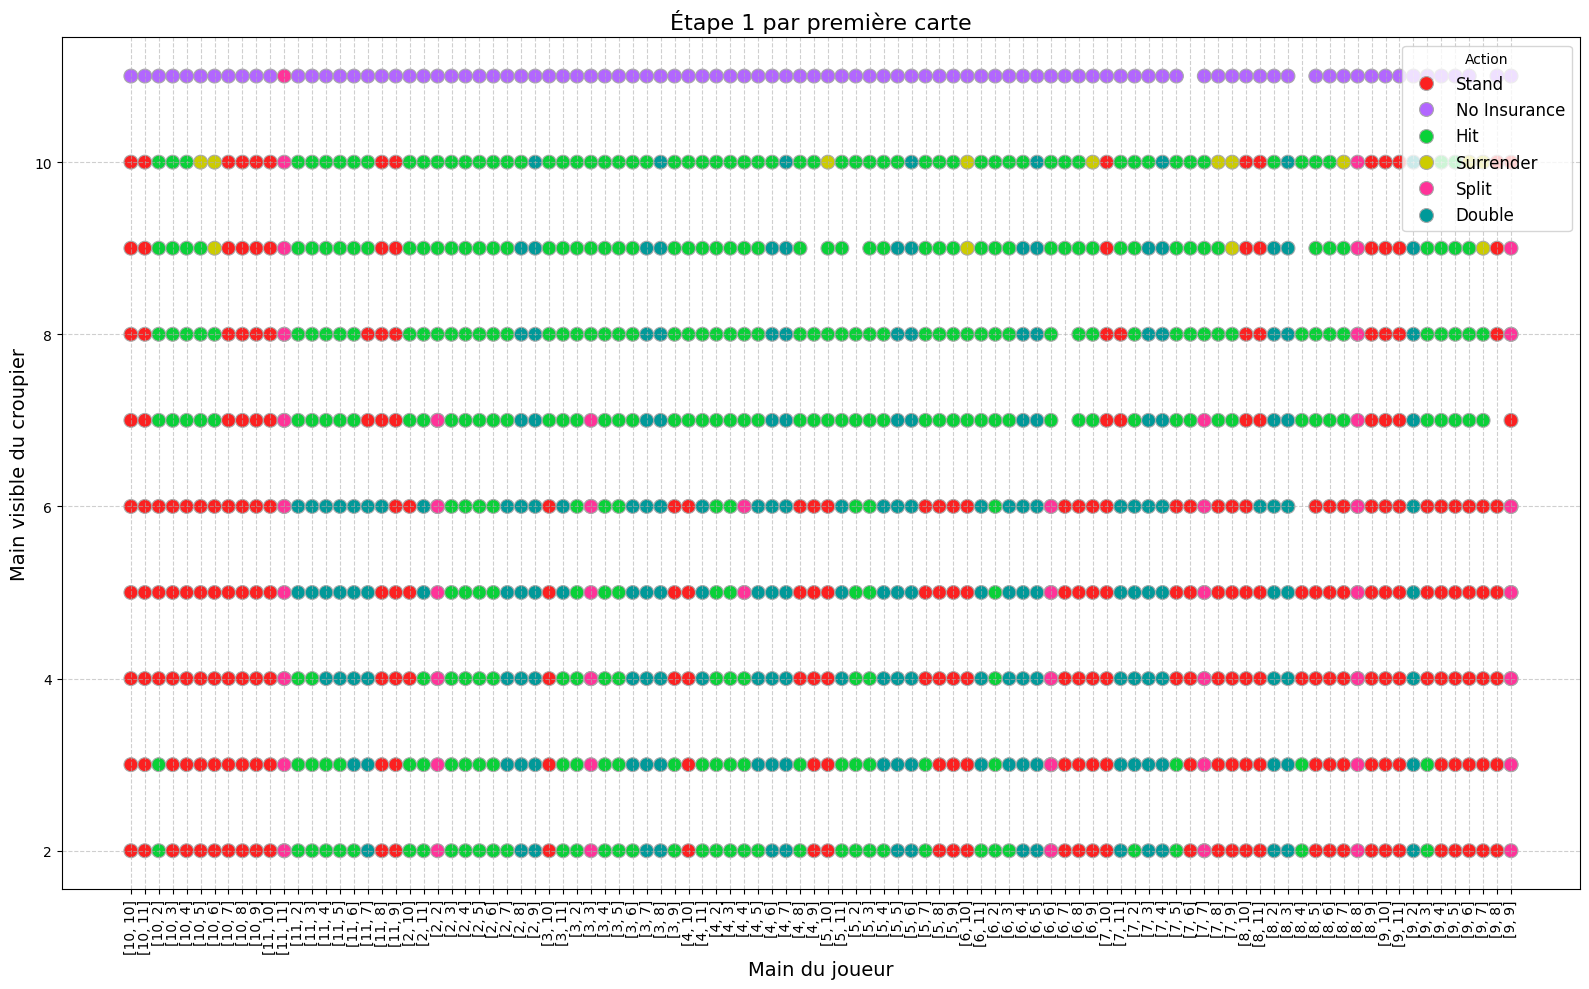

In [ ]:
StepBy1stHand = data[['initial_hand', 'dealer_up', 'win', 'action_taken_1']]
StepBy1stHand['initial_hand'] = StepBy1stHand['initial_hand'].astype(str)
GraphD = StepBy1stHand.query('win == 1')
GraphD['Counts'] = GraphD.groupby(['initial_hand', 'dealer_up'])['action_taken_1'].transform('count')
MaxIndexD = GraphD.groupby(['initial_hand', 'dealer_up'])['Counts'].idxmax().drop_duplicates()
NewGraphD = GraphD.loc[MaxIndexD, :].sort_values(['initial_hand', 'dealer_up']).fillna('No Data')
NewGraphD = NewGraphD.replace({
    'S': 'Stand',
    'H': 'Hit',
    'D': 'Double',
    'P': 'Split',
    'R': 'Surrender',
    'N': 'No Insurance',
})

plt.figure(figsize=(16, 10))
scatterplot = sns.scatterplot(
    data=NewGraphD,
    x='initial_hand',
    y='dealer_up',
    hue='action_taken_1',
    palette={
        'Stand': '#FC2020',
        'Hit': '#09D138',
        'Double': "#009999",
        'Split': '#FF3399',
        'Surrender': "#CCCC00",
        'No Insurance': "#B266FF",
        'No Data': '#C0C0C0'
    },
    s=100,
    edgecolor='darkgrey'
)

scatterplot.set_title('Étape 1 par première carte', fontsize=16)
scatterplot.set_xlabel("Main du joueur", fontsize=14)
scatterplot.set_ylabel("Main visible du croupier", fontsize=14)
scatterplot.legend(title='Action', loc='upper right', fontsize=12)

# Rotation des labels de l'axe x
plt.xticks(rotation=90)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Ajuste automatiquement les marges pour éviter le chevauchement
plt.show()

Pour approfondir notre compréhension des stratégies gagnantes, nous avons créé une visualisation qui met en relation :
- La main initiale du joueur (2 premières cartes)
- La carte visible du croupier
- L'action recommandée menant le plus souvent à la victoire

Cette représentation sous forme de graphique à points nous permet d'identifier rapidement :
- Les situations où un split est recommandé (paires)
- Les mains fortes nécessitant de rester (stand)
- Les mains faibles nécessitant de tirer (hit)
- Les opportunités de doubler (double)

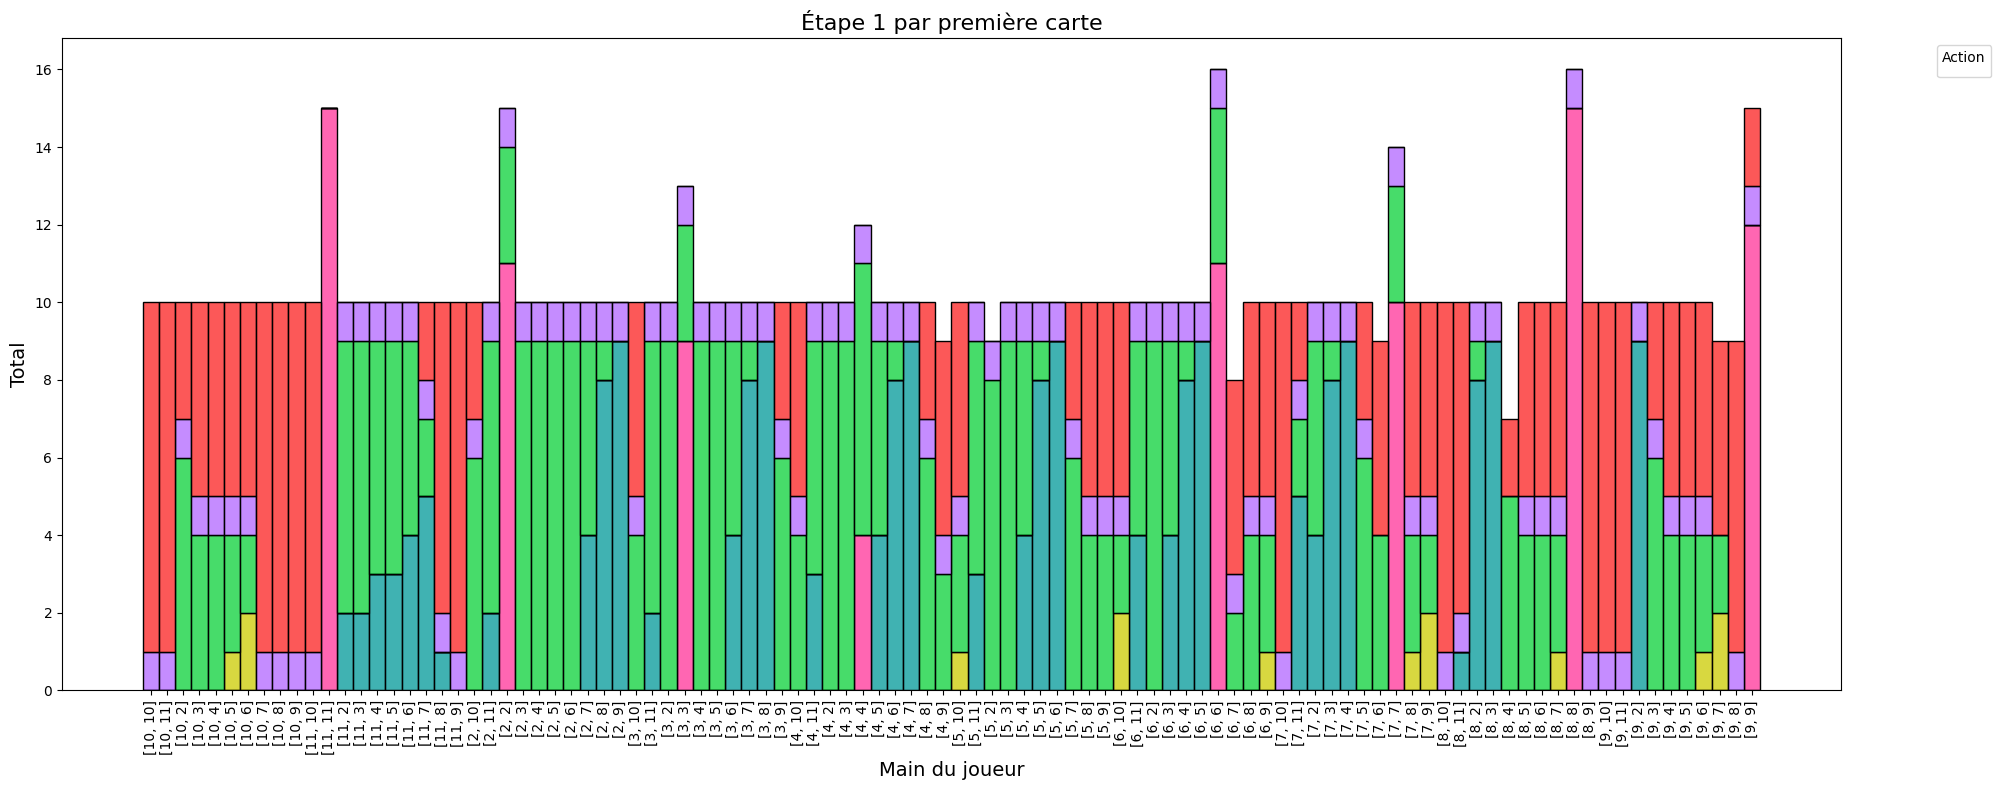

In [ ]:
StepBy1stHand = data[['initial_hand', 'dealer_up', 'win', 'action_taken_1']]
StepBy1stHand['initial_hand'] = StepBy1stHand['initial_hand'].astype(str)
GraphD = StepBy1stHand.query('win == 1')
GraphD['Counts'] = GraphD.groupby(['initial_hand', 'dealer_up'])['action_taken_1'].transform('count')
MaxIndexD = GraphD.groupby(['initial_hand', 'dealer_up'])['Counts'].idxmax().drop_duplicates()
NewGraphD = GraphD.loc[MaxIndexD,:].sort_values(['initial_hand', 'dealer_up']).fillna('No Data')
NewGraphD = NewGraphD.replace({
    'S': 'Stand',
    'H': 'Hit',
    'D': 'Double',
    'P': 'Split',
    'R': 'Surrender',
    'N': 'No Insurance'
})

plt.figure(figsize=(20, 8))

color_map = {
    'Stand': '#FC2020',
    'Hit': '#09D138',
    'Double': "#009999",
    'Split': '#FF3399',
    'Surrender': "#CCCC00",
    'No Insurance': "#B266FF",
    'No Data': '#C0C0C0'
}

sns.histplot(
    data=NewGraphD,
    x='initial_hand',
    hue='action_taken_1',
    palette=color_map,
    multiple="stack"
)

plt.title('Étape 1 par première carte', fontsize=16)
plt.xlabel("Main du joueur", fontsize=14)
plt.ylabel("Total", fontsize=14)

plt.xticks(rotation=90)

plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()

Pour compléter l'analyse précédente, nous avons créé un histogramme empilé qui montre :
- La fréquence des différentes actions pour chaque main initiale possible
- La distribution complète des décisions gagnantes
- Le nombre total d'occurrences de chaque combinaison

Ce graphique nous permet de mieux comprendre les situations où plusieurs actions peuvent être viables, ainsi que la prédominance de certaines décisions selon la main de départ.

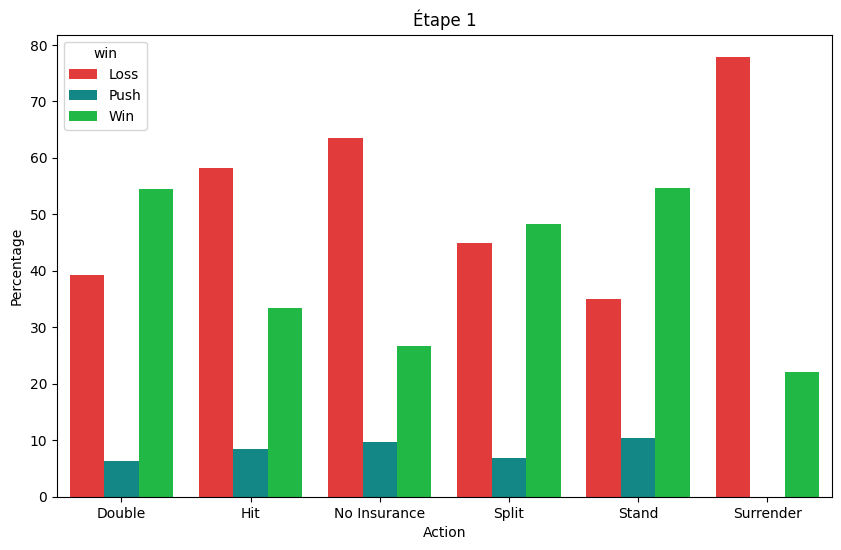

In [ ]:
def win_by_action_graph_generator(data, step, norm):
    graphdata = data[[f'action_taken_{step}', 'win']]
    graphdata = graphdata.replace({
        'S': 'Stand',
        'H': 'Hit',
        'D': 'Double',
        'P': 'Split',
        'R': 'Surrender',
        'N': 'No Insurance',
        1: 'Win',
        0: 'Push',
        -1: 'Loss'
    })

    # Créer un groupby pour compter les occurrences
    grouped_data = graphdata.groupby([f'action_taken_{step}', 'win']).size().reset_index(name='count')

    plt.figure(figsize=(10, 6))
    if norm:
        total = grouped_data.groupby(f'action_taken_{step}')['count'].transform('sum')
        grouped_data['percentage'] = grouped_data['count'] / total * 100
        sns.barplot(
            data=grouped_data,
            x=f'action_taken_{step}',
            y='percentage',
            hue='win',
            palette={'Loss': '#FC2020', 'Win': '#09D138', 'Push': '#009999'}
        )
        plt.ylabel('Percentage')
    else:
        sns.barplot(
            data=grouped_data,
            x=f'action_taken_{step}',
            y='count',
            hue='win',
            palette={'Loss': '#FC2020', 'Win': '#09D138', 'Push': '#009999'}
        )
        plt.ylabel('Count')

    plt.title(f'Étape {step}')
    plt.xlabel('Action')
    plt.show()

win_by_action_graph_generator(data, 1, True)


Notre visualisation des résultats par type d'action révèle un pattern intéressant et contre-intuitif : l'action "Stand" (rester) montre généralement les meilleures chances de victoire, indépendamment de la main.

Le graphique montre pour chaque action possible :
- Le pourcentage de victoires (vert)
- Le pourcentage de défaites (rouge)
- Le pourcentage d'égalités (bleu)

Cette observation est particulièrement importante car elle :
- Remet en question certaines stratégies communes plus agressives
- Suggère une approche plus conservatrice dans le jeu
- Souligne l'importance de la patience dans la stratégie de jeu

Nous allons créer un nouveau graphique pour étayer cette hypothèse, en visualisant le taux moyen de victoires en fonction du nombre de cartes du joueur :

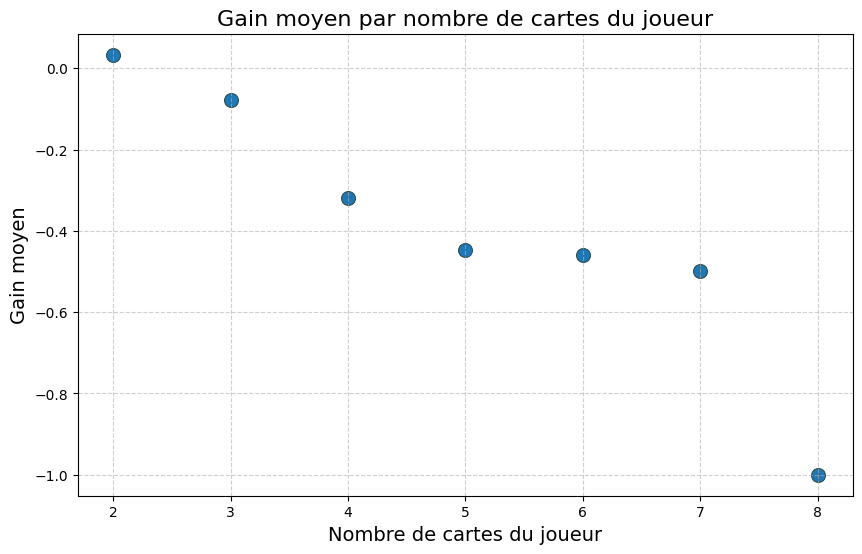

In [ ]:
WinMean = pd.DataFrame(data['win'])
WinMean['len'] = data['player_final'].apply(lambda x: len(x))
WinMeanPlotData = pd.DataFrame(WinMean.groupby(['len'])['win'].mean()).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=WinMeanPlotData, x='len', y='win', s=100, edgecolor='darkslategrey')

plt.xlabel("Nombre de cartes du joueur", fontsize=14)
plt.ylabel("Gain moyen", fontsize=14)
plt.title("Gain moyen par nombre de cartes du joueur", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

Cette analyse confirme notre hypothèse précédente. Le graphique montre une diminution constante des chances de victoire avec l'augmentation du nombre de cartes.

Point crucial : avec seulement 2 cartes (stand immédiat après la distribution initiale), la moyenne de gain est **positive**, ce qui renforce notre observation sur l'efficacité de la stratégie conservatrice.

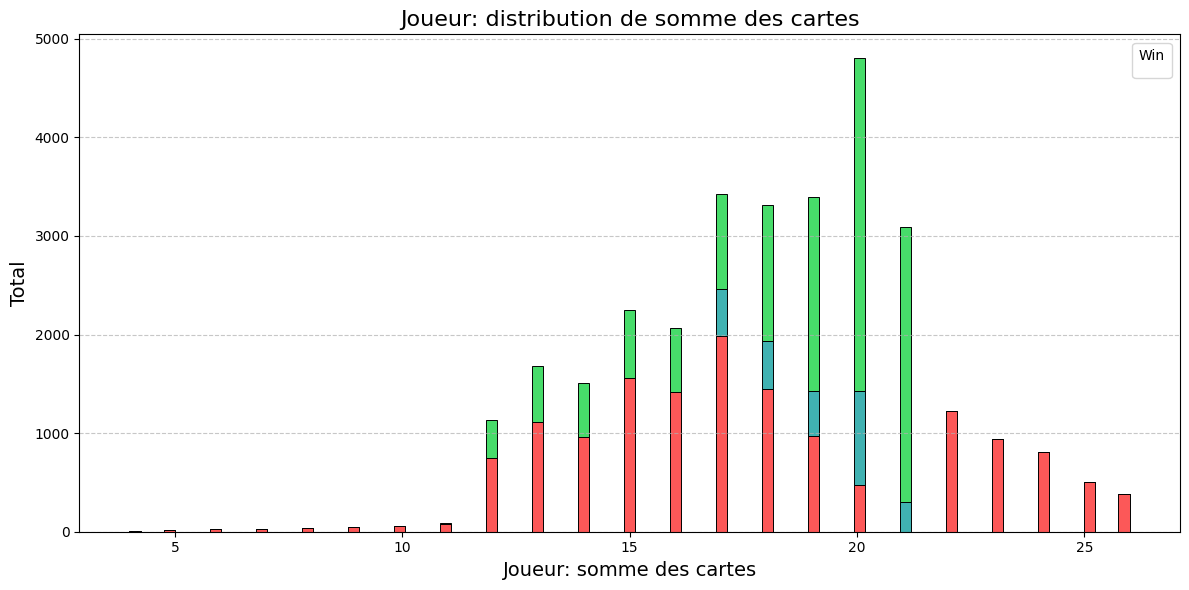

In [ ]:
def win_total_graph_generator(data, selection):
    if selection == 'croupier':
        graphdata = data[['dealer_final_value', 'win']].replace({-1: 'Win', 0: 'Push', 1: 'Loss'})
        value_column = 'dealer_final_value'
    elif selection == 'joueur':
        graphdata = data[['player_final_value', 'win']].replace({1: 'Win', 0: 'Push', -1: 'Loss'})
        value_column = 'player_final_value'

    plt.figure(figsize=(12, 6))
    sns.histplot(data=graphdata, x=value_column, hue='win', multiple='stack', palette={'Loss': '#FC2020', 'Win': '#09D138', 'Push': '#009999'})

    plt.title(f"{selection.title()}: distribution de somme des cartes", fontsize=16)
    plt.xlabel(f"{selection.title()}: somme des cartes", fontsize=14)
    plt.ylabel('Total', fontsize=14)
    plt.legend(title='Win', fontsize=12, loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

win_total_graph_generator(data, 'joueur')



L'analyse de la distribution des résultats révèle des patterns logiques :

- Pour une somme de 21 :
  - Uniquement des victoires ou des égalités
  - Aucune défaite possible

- Pour une somme supérieure à 21 :
  - 100% de défaites (zone rouge)
  - Confirme la règle du "bust"

Ces observations confirment la cohérence de nos données avec les règles du Blackjack et valident la qualité de notre jeu de données pour l'entraînement de notre modèle.

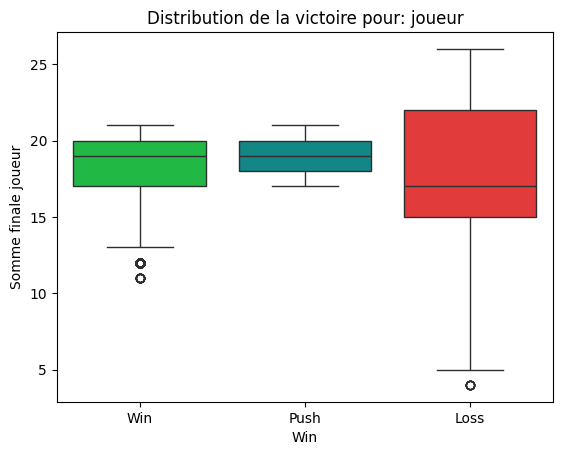

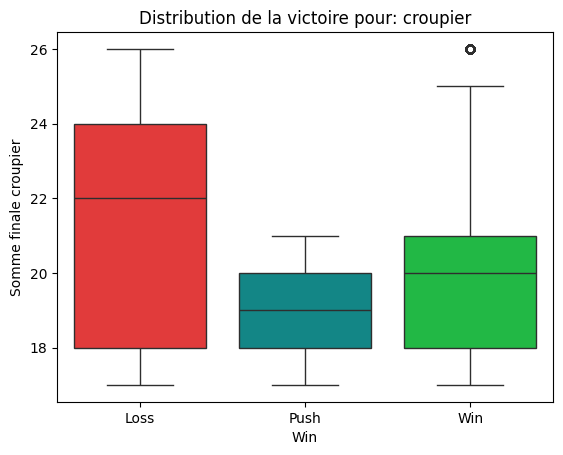

In [ ]:
def win_box_plot_generator_seaborn(data, side):
    if side == 'croupier':
        plot_data = data.replace({1: 'Loss', 0: 'Push', -1: 'Win'})
        sns.boxplot(data=plot_data, x='win', y='dealer_final_value', palette={'Loss': '#FC2020', 'Win': '#09D138', 'Push': "#009999"})
        plt.title(f'Distribution de la victoire pour: {side}')
        plt.xlabel("Win")
        plt.ylabel("Somme finale croupier")
        plt.show()
    elif side == 'joueur':
        plot_data = data.replace({1: 'Win', 0: 'Push', -1: 'Loss'})
        sns.boxplot(data=plot_data, x='win', y='player_final_value', palette={'Loss': '#FC2020', 'Win': '#09D138', 'Push': "#009999"})
        plt.title(f'Distribution de la victoire pour: {side}')
        plt.xlabel("Win")
        plt.ylabel("Somme finale joueur")
        plt.show()

def show_win_box_plot_seaborn(side='player'):
    win_box_plot_generator_seaborn(data, side)


show_win_box_plot_seaborn(side='joueur')
show_win_box_plot_seaborn(side='croupier')

L'analyse de la distribution totale révèle des comportements intéressants :

### Pour le Dealer
- Le minimum de cartes est toujours 17 (règle du jeu)
- Des victoires apparentes avec plus de 21 points s'expliquent : le dealer gagne automatiquement si le joueur a "bust" avant lui

### Pour le Joueur
- Distribution plus large des sommes possibles
- Zone verte (victoires) principalement concentrée entre 17 et 21
- Au-delà de 21, uniquement des défaites

Note importante : Dans ces graphiques, la "victoire" est relative au point de vue analysé (dealer ou joueur).